In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter
import os
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.utils import plot_model

In [7]:
##Defining batch size
batch_size = 100
img_height = 250
img_width = 250

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
## loading training set
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/data/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 679 files belonging to 2 classes.


In [9]:
## loading validation dataset
validation_data =  tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/data/val',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 61 files belonging to 2 classes.


In [10]:
## loading testing dataset
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/data/test',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 94 files belonging to 2 classes.


In [11]:
testing_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
class_names = training_data.class_names
class_names

['Accident', 'Non Accident']

In [13]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
## Defining Cnn
model = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'), # Conv2D(f_size, filter_size, activation) # relu, sigmoid, softmax
  layers.MaxPooling2D(), # MaxPooling
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.build((None, 250, 250, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 250, 250, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 248, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 27, 27, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      22,151,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,541,134 (85.99 MB)

 Trainable params: 22,541,128 (85.99 MB)

 Non-trainable params: 6 (24.00 B)

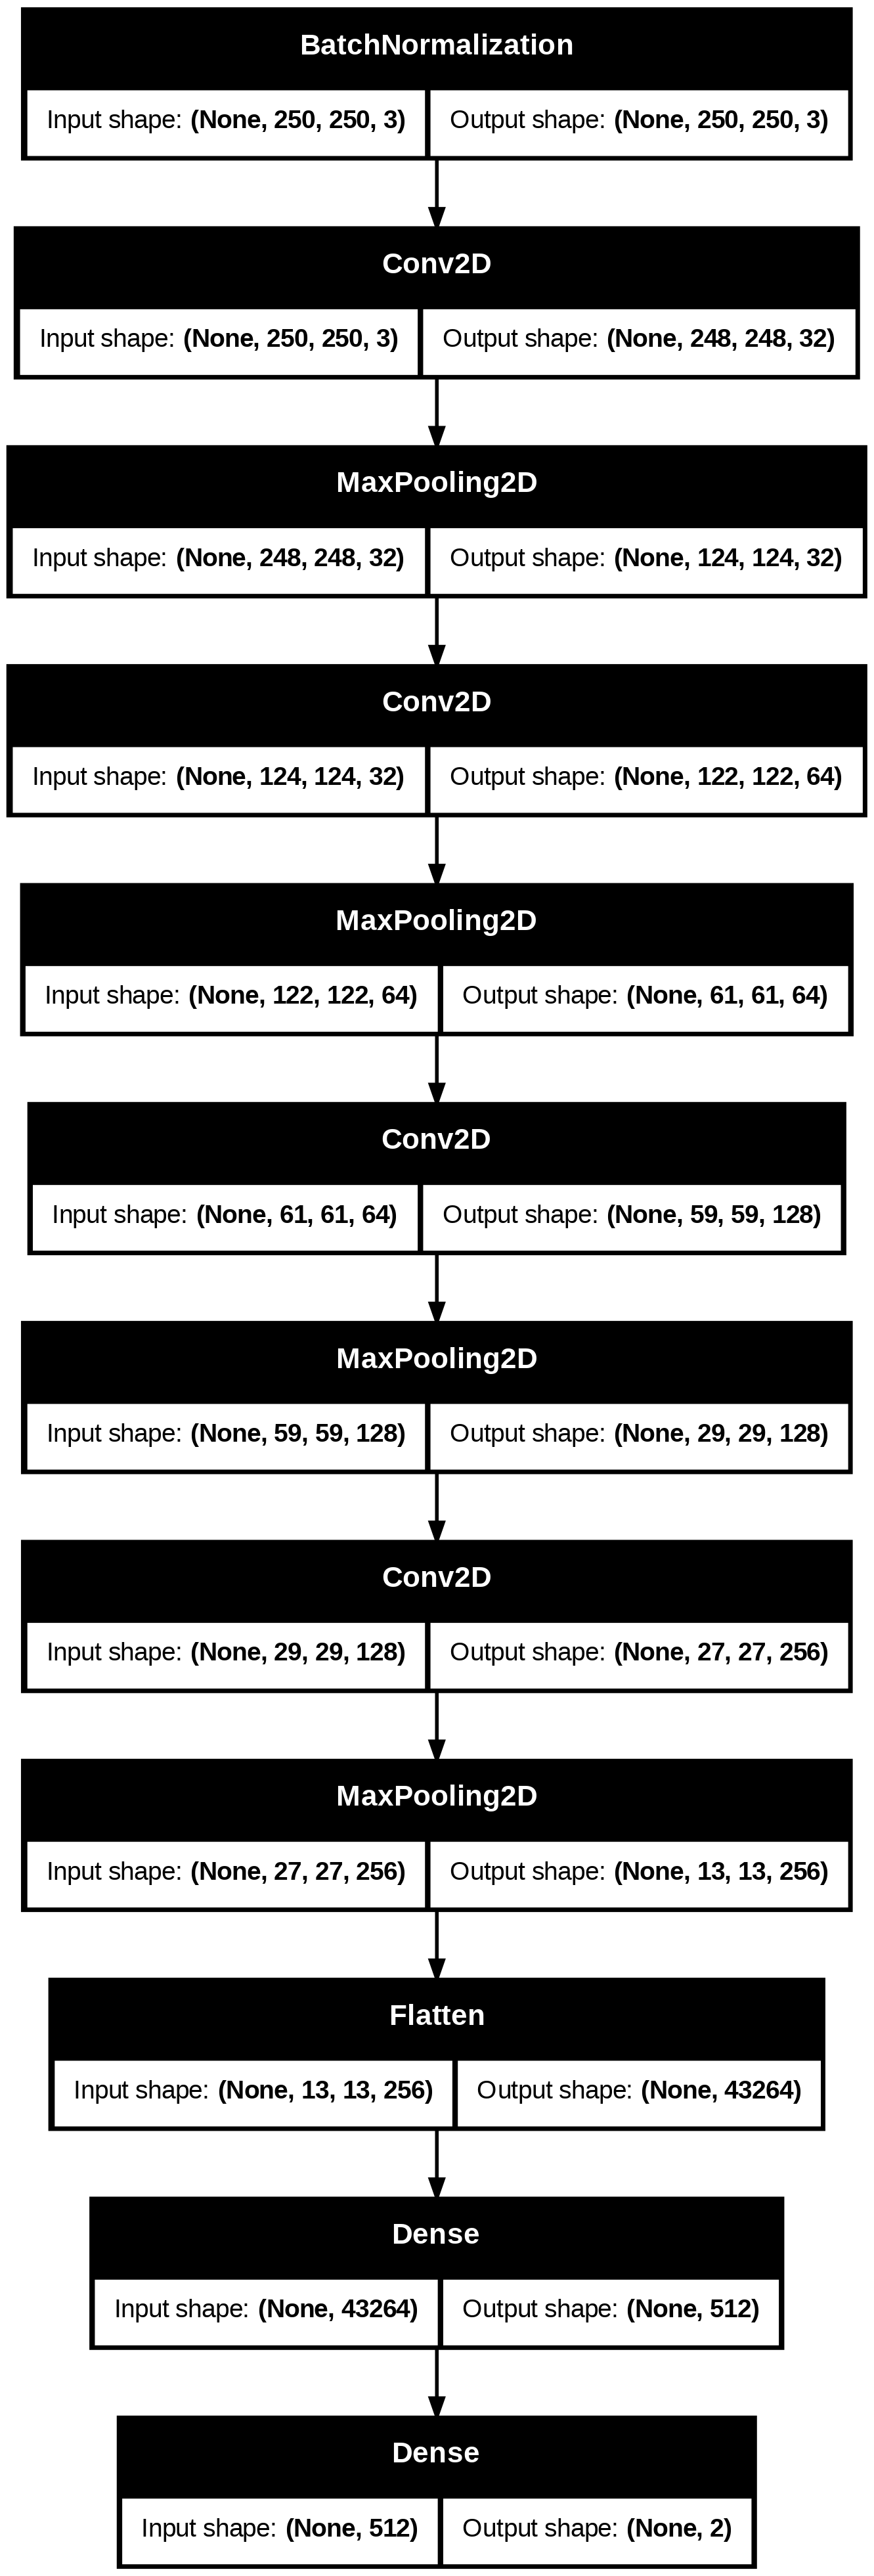

In [16]:
plot_model(model, show_shapes=True)

In [17]:
## lets train our CNN
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(training_data, validation_data=validation_data, epochs = 20, callbacks=callbacks_list)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5504 - loss: 5.1894 
Epoch 1: val_accuracy improved from -inf to 0.54098, saving model to model_weights.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 172s 22s/step - accuracy: 0.5482 - loss: 5.0127 - val_accuracy: 0.5410 - val_loss: 0.9995
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.5848 - loss: 0.6597 
Epoch 2: val_accuracy improved from 0.54098 to 0.55738, saving model to model_weights.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 169s 19s/step - accuracy: 0.5852 - loss: 0.6588 - val_accuracy: 0.5574 - val_loss: 0.8844
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.6135 - loss: 0.6427 
Epoch 3: val_accuracy improved from 0.55738 to 0.65574, saving model to model_weights.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 136s 19s/step - accuracy: 0.6191 - loss: 0.6399 - val_accuracy: 0.6557 - val_loss: 0.5739
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.7285 - loss: 0.5422 
Epoch 4: val_accuracy did not improve from 0.65574
7/7 ━━━━━━━━━━━━━━━━━━━━ 130s 19s/step - accuracy: 0.7276 - loss: 0.5433 - val_accuracy: 0.6230 - val_loss: 0.7133
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.7651 - loss: 0.4711 
Epoch 5: val_accuracy did not improve from 0.65574
7/7 ━━━━━━━━━━━━━━━━━━━━ 139s 18s/step - accuracy: 0.7648 - loss: 0.4719 - val_accuracy: 0.6230 - val_loss: 0.6072
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.8142 - loss: 0.3855 
Epoch 6: val_accuracy improved from 0.65574 to 0.70492, saving model to model_weights.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 157s 21s/step - accuracy: 0.8146 - loss: 0.3858 - val_accuracy: 0.7049 - val_loss: 0.5368
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8805 - loss: 0.3124 
Epoch 7: val_accuracy improved from 0.70492 to 0.77049, saving model to model_weights.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 129s 18s/step - accuracy: 0.8806 - loss: 0.3105 - val_accuracy: 0.7705 - val_loss: 0.5728
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8928 - loss: 0.2468 
Epoch 8: val_accuracy improved from 0.77049 to 0.80328, saving model to model_weights.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 127s 18s/step - accuracy: 0.8941 - loss: 0.2444 - val_accuracy: 0.8033 - val_loss: 0.5547
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9289 - loss: 0.1753 
Epoch 9: val_accuracy did not improve from 0.80328
7/7 ━━━━━━━━━━━━━━━━━━━━ 141s 18s/step - accuracy: 0.9313 - loss: 0.1723 - val_accuracy: 0.8033 - val_loss: 0.7110
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9622 - loss: 0.1105 
Epoch 10: val_accuracy improved from 0.80328 to 0.83607, saving model to model_weights.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 127s 18s/step - accuracy: 0.9627 - loss: 0.1091 - val_accuracy: 0.8361 - val_loss: 0.5273
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9468 - loss: 0.1194 
Epoch 11: val_accuracy did not improve from 0.83607
7/7 ━━━━━━━━━━━━━━━━━━━━ 137s 18s/step - accuracy: 0.9466 - loss: 0.1211 - val_accuracy: 0.8361 - val_loss: 0.4494
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9463 - loss: 0.1374 
Epoch 12: val_accuracy did not improve from 0.83607
7/7 ━━━━━━━━━━━━━━━━━━━━ 127s 18s/step - accuracy: 0.9473 - loss: 0.1351 - val_accuracy: 0.8197 - val_loss: 0.5438
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9751 - loss: 0.0696 
Epoch 13: val_accuracy did not improve from 0.83607
7/7 ━━━━━━━━━━━━━━━━━━━━ 127s 18s/step - accuracy: 0.9749 - loss: 0.0698 - val_accuracy: 0.7869 - val_loss: 0.4756
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9774 - loss: 0.0602 
Epoch 14: val_accuracy did not improve from 0.83

7/7 ━━━━━━━━━━━━━━━━━━━━ 127s 18s/step - accuracy: 0.9737 - loss: 0.0696 - val_accuracy: 0.9180 - val_loss: 0.2593
Epoch 19/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9791 - loss: 0.0639 
Epoch 19: val_accuracy did not improve from 0.91803
7/7 ━━━━━━━━━━━━━━━━━━━━ 127s 18s/step - accuracy: 0.9794 - loss: 0.0644 - val_accuracy: 0.8033 - val_loss: 0.5835
Epoch 20/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9762 - loss: 0.0895 
Epoch 20: val_accuracy improved from 0.91803 to 0.95082, saving model to model_weights.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 152s 20s/step - accuracy: 0.9765 - loss: 0.0878 - val_accuracy: 0.9508 - val_loss: 0.1360


In [ ]:
# Save model architecture to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights
model.save_weights("model_weights.h5")  


: 

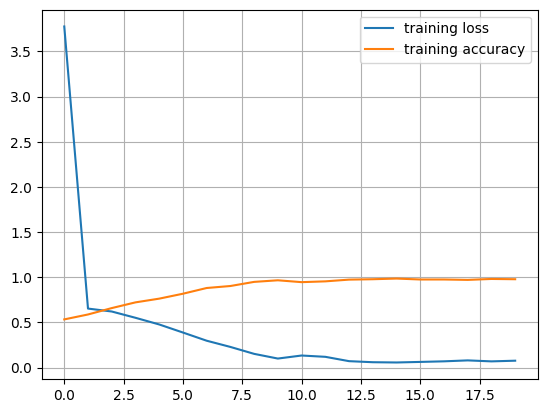

In [19]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()


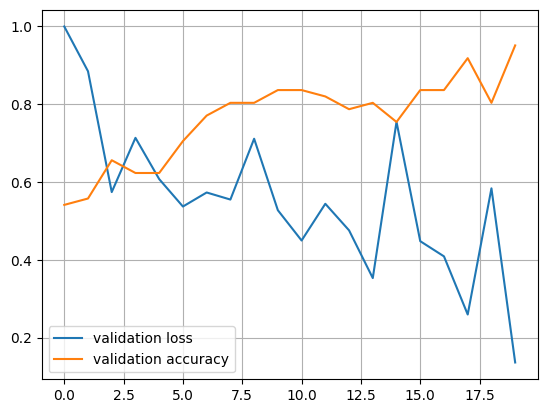

In [20]:
## stats on training data
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


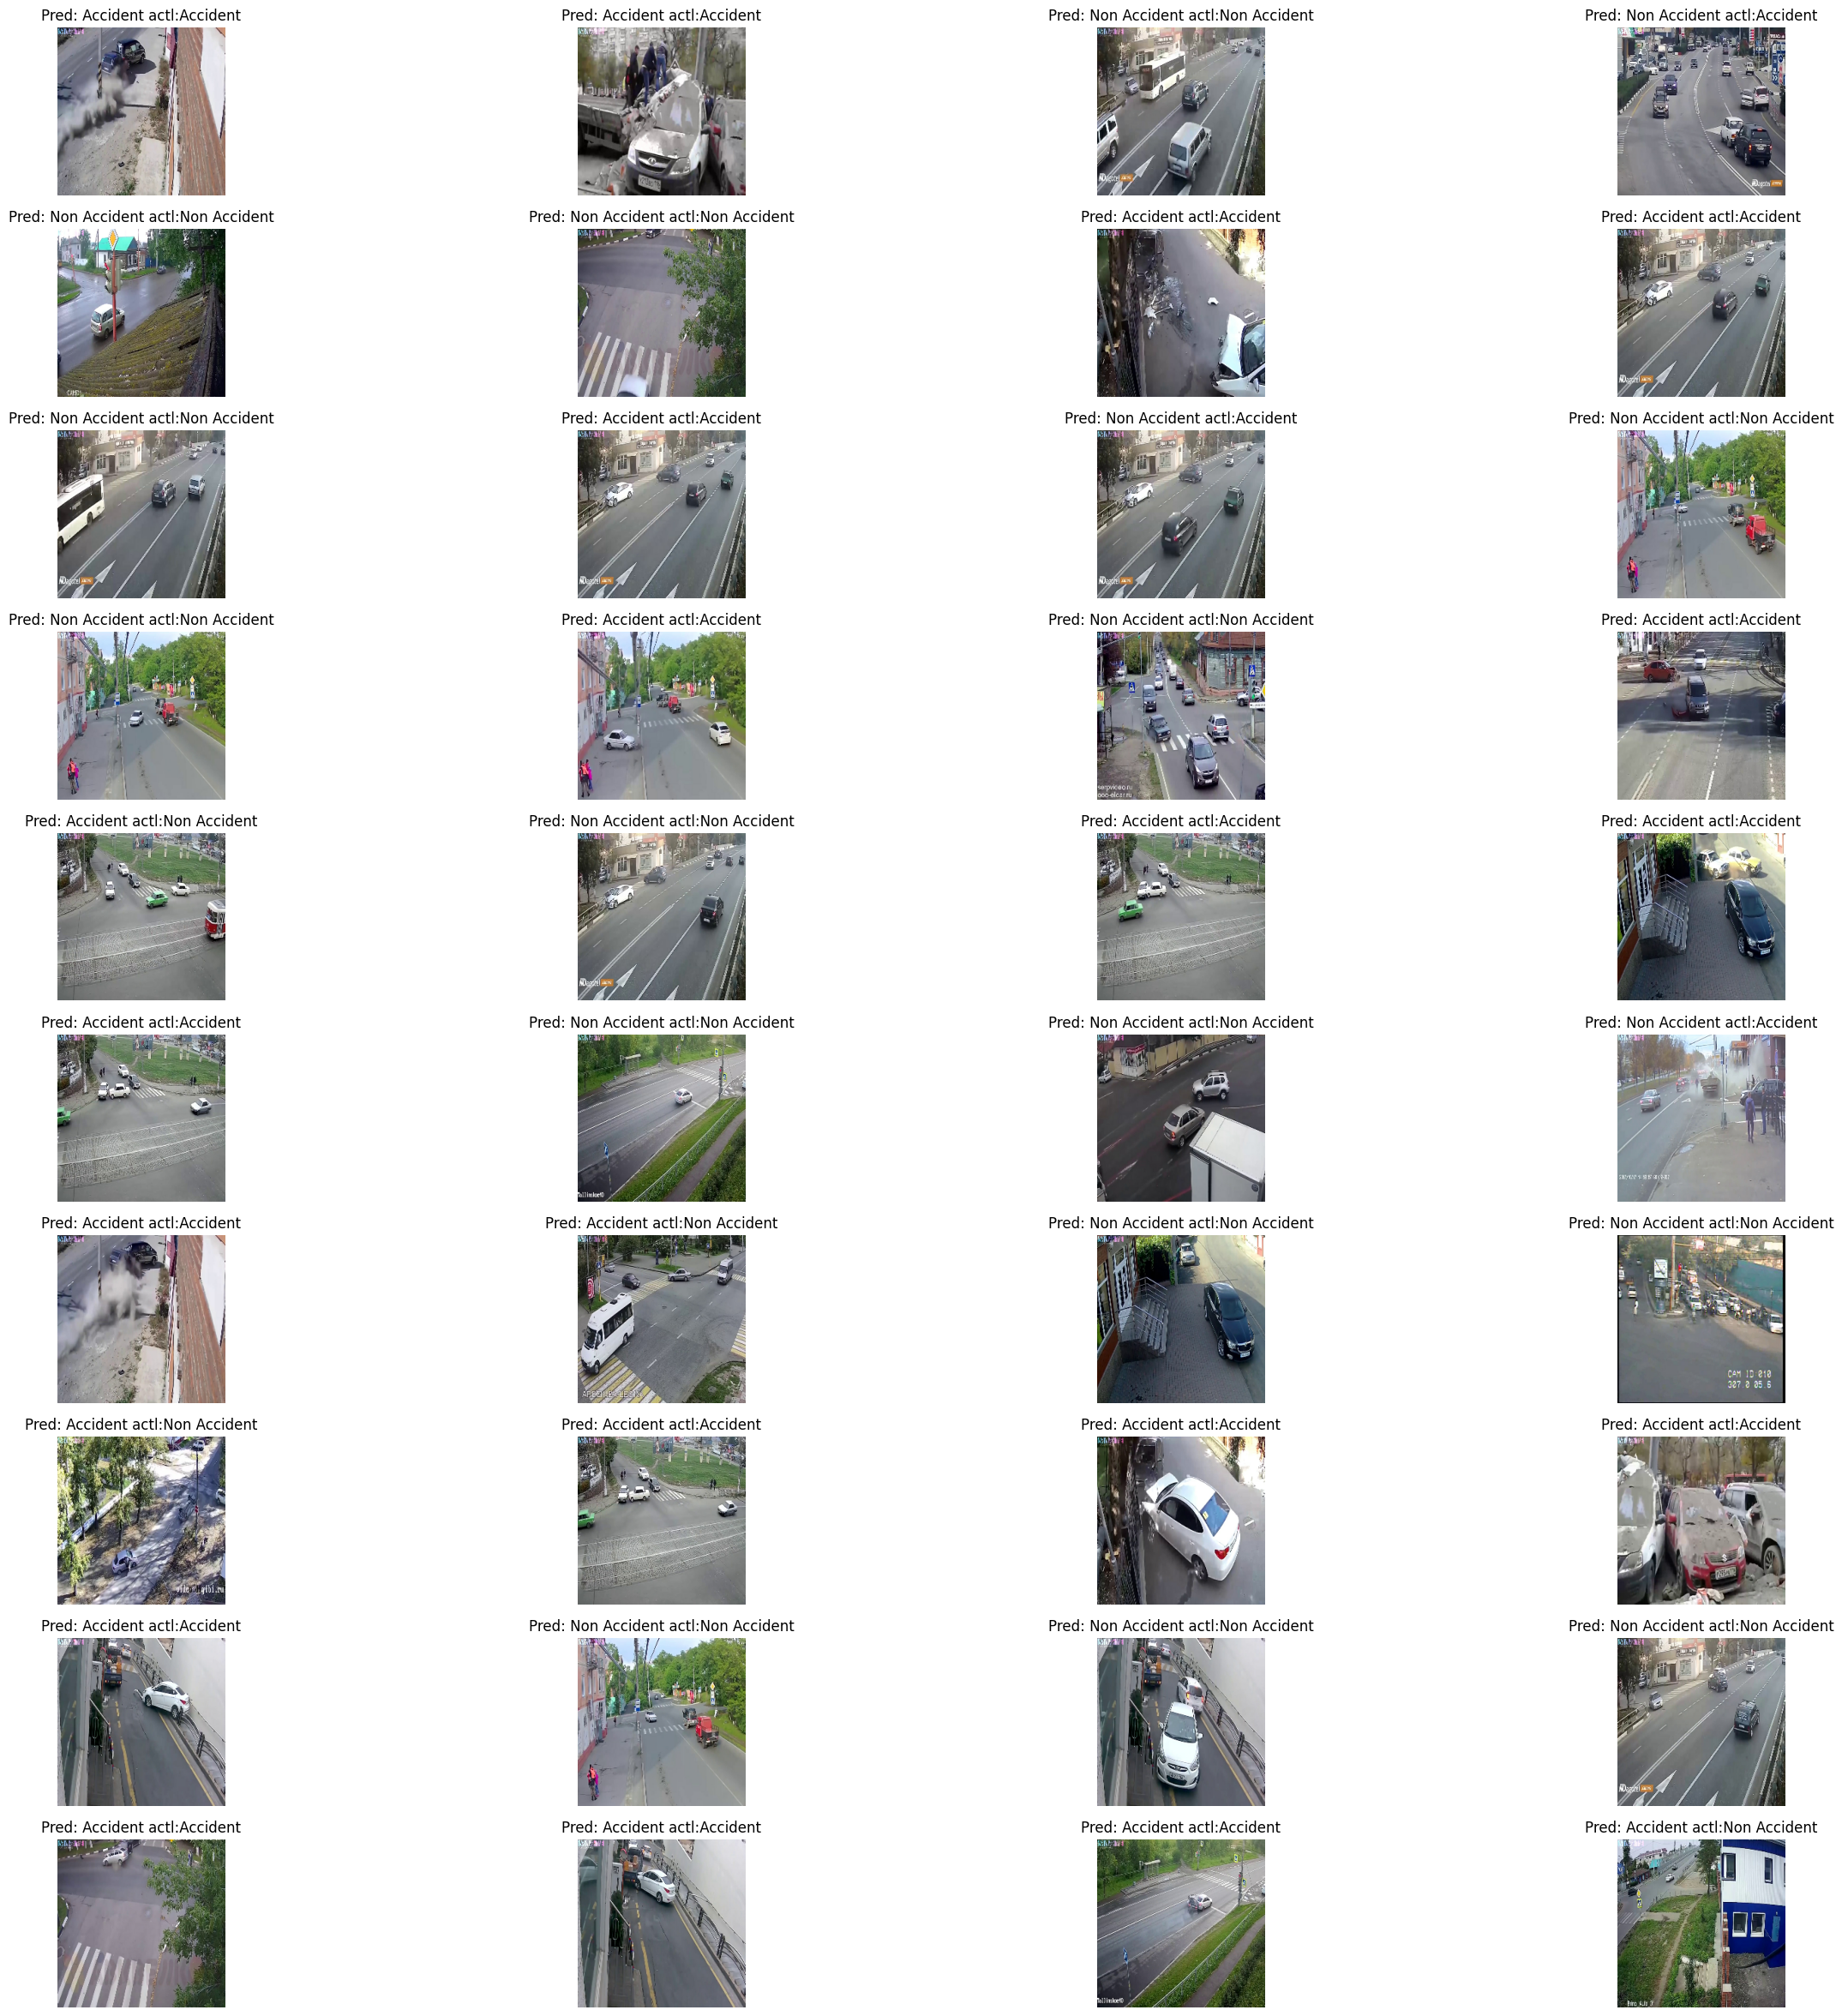

In [21]:
## lets vizualize results on testing data
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))

    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)